# Introduction to GeoPandas for Working with Geospatial Vector Data (i.e., shapes: points, lines, and polygons)

# I. Importing Necessary Packages

In [1]:
import geopandas as gpd
# import shapely
# import fiona
import pyogrio

# to avoid the GDAL error you need to activate the environment before launching jupyter

ModuleNotFoundError: No module named 'geopandas'

# II. Why use Python GeoPandas for geospatial data analysis as opposed to ArcGIS or other GIS software?

If most or all of the data you work with are vector-based spatial data formats such as shapefiles, GeoJSON, or geodatabases, using GIS software will be more desirable and efficient!

On the other hand, if most of the data you work with are not in these formats and your workflow is primarily in Python, GeoPandas may be the tool for you. For example, for a geoscientist (earth, environmental, climate sciences) who works most often with large multi-dimensional data arrays (time,level,lat,lon) in formats like .nc, .tif, .grib, .hdf, .csv, Python will be a much more efficient and reproducible tool for scientific analysis. For this use case, packages like GeoPandas make working with the occasional shapefile or geodatabase very easy within your existing Python workflow instead of having to use a separate GIS tool for part of your analysis.

As we proceed through this notebook, we'll be looking at just of few of Python's geospatial analysis capabilities, mainly in the context that use of these tools is likely a minor part of a larger analysis using Python.

# III. Introduction to GeoPandas Data Structures

GeoPandas extends the Pandas package by adding support for geospatial vector data (i.e., shapes: points, lines, polygons). Under the hood, GeoPandas uses geometric operations from another Python package called [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).

The core data structure in GeoPandas is the *GeoDataFrame*, which is similar to a Pandas DataFrame made up of an index and collection of *Series* (columns) as well as a special column named "geometry". The geometery column is a *GeoSeries* which is a special structure that can handle shapes (or "geometries") like points, lines, and polygons. Each shape object in a GeoPandas GeoSeries is a Shapely geometry object. A GeoDataFrame can contain as many Series and GeoSeries as you want.        

Below is a schematic of what a GeoPandas GeoDataFrame looks like, where the green boxes indicate the index, yellow boxes indicate data (with column names) in Series structures and pink boxes show a single GeoSeries structure which would have the column name "geometry".


<img src="images/geodataframe.svg" alt="schematic of a dataframe" width="700"/> 
         
(Image Source: [GeoPandas Docs Getting Started Tutorial](https://geopandas.org/en/stable/getting_started/introduction.html#Concepts)

# IV. Loading a ShapeFile into a GeoDataFrame

Most of the time you'll probably start a geospatial analysis with a shapefile or geodatabase, both of which are comprised of multiple components. Three components are mandatory for shapefiles: 
- a main file that contains the feature geometry (.shp),
- an index file that stores the index of the feature geometry (.shx), and
- a dBASE table (.dbf) that stores the attribute information of features.

The shapefiles we'll load contain the boundaries for a few US states and the centerlines for some large rivers. The files we're using contain subsets of data from larger files that are publicly available from the US Census Bureau and Natural Earth data project. If you're interested, the full data files are [cb_2023_us_state_500k.shp from the Census Bureau cartographic boundary files](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) and [ne_10m_rivers_lake_centerlines.shp, ne_10m_rivers_north_america.shp from the Natural Earth data project](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-rivers-lake-centerlines/).

```geopandas.read_file()``` can read almost any vector-based spatial data format.

In [2]:
# load state boundaries from shapefile
gdf_states = gpd.read_file('data/state_boundaries/MS_LA_AR_AL_TN_cb_2023_us_state_500km.shp')
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524...."
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1..."
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1..."
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0..."
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125...."


This is a GeoPandas GeoDataFrame and as you can see, it looks a lot like a Pandas DataFrame. Each row is a data entry for a different state. Notice the rightmost column named "geometry". It contains geospatial shapes that represent the boundaries of each state. 

Let's look at the data type of each column

In [3]:
gdf_states.dtypes

STATEFP       object
STATENS       object
GEOIDFQ       object
GEOID         object
STUSPS        object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

You should remember seeing most of these data types from the Pandas notebook, but GeoPandas adds a new data type "geometry". This is indicating that the column named "geometry" is a GeoSeries that contains geospatial shapes.

Since there is only one column of type geometry, GeoPandas makes that column the "active geometry column." You can have more than one GeoSeries column that contain shapes, but only one active at a time. This doesn't really come into  play until it's time to create figures. 

Look onces again at the geometry column of the GeoDataFrame. Notice the values inside the geospatial shapes. What are those numbers? Each set of numbers (separated by commas) is a x,y node (point) that make up the shape. Large numbers, like we have, usually indicate that the data is in a coordinate reference system that has units of meters (as opposed to degrees latitude and longitude). We'll talk about coordinate reference systems next.

# V. Coordinate Reference Systems (CRS)

A CRS is a framework used to locate and map geographic features on the Earth's surface. The key components of a CRS are:

- **Coordinate System:** Defines the grid used to specify locations on the Earth, including the axes (like latitude/longitude or X/Y) and distance units of measurement (degrees or meters, for example). 

- **Datum:** The modeled version of the shape of the earth (usually represented by an ellipsoid). The datum also defines the origin (or reference point) of the coordinate system.

- **Projection:** A mathematical transformation that translates the spherical coordinates on the Earth's surface onto a flat surface like a map. No projection is perfect. Each will have different distortions which can affect area, shape, distance, and/or direction. Different projections are used based on the area of interest and the purpose of the map. Some coordinate reference systems do not have a projection, meaning their coordinate system and datum define locations on a 3-dimensional Earth rather than a 2-dimensional map. 


As mentioned above, there are actually two types of CRS's: geographic coordinate reference systems and projected coordinate reference systems.

- **Geographic coordinate reference systems** are used to locate places on a 3-dimensional Earth surface based on two values, longitude and latitude, usually with units of decimal degrees. Units of angular distances are not linear due to the polar convergence of longitudes and the slight bulge of the earth at the equator. Therefore, a geographic CRS is not suitable to calculate or compare distances between locations. A common geographic CRS would be EPSG:4326, which uses a latitude and longitude coordinate system and the WGS84 (an ellipsoid) datum to represent locations on the whole Earth. Confusingly, sometimes this CRS is referred to as the WGS84 CRS. I like to use the EPSG codes when discussing CRS's because they are unique identifiers that can eliminate a lot of confusion. EPSG:4326 is the default CRS used in many GPS systems and is also used by Google Earth.
- **Projected coordinate reference systems** are based on a Cartesian coordinate system on a flat surface. Map projections are used to convert the 3D surface of the Earth into x and y coordinates of the projected CRS. A common projected CRS that you may encounter is EPSG:3857, also known as the Web Mercator projection. This CRS is used for many web mapping applications include Google Maps and Apple Map.


Your choice of CRS will depend on how big your area of interest is, the region of the globe where it is located, and what you want to calculate. Projections that preserve shape are called conformal; those that preserve area are called equal-area; those that preserve distance are called equidistant; and those that preserve direction are called azimuthal. These words might assist you in finding a projected CRS that preserves that geospatial properties most important to your analysis. Also, keep in mind that you can "reproject" from one CRS to another to increase the accuracy of calculations that require preservation of different geospatial properties (e.g. area vs distance) .

Let's see what CRS our state boundaries use:

In [4]:
gdf_states.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The CRS of this data is EPSG:5070, which uses the NAD83 datum and an X/Y Cartesian coordinate system with units in meters. The information GeoPandas gives us let's us know that this CRS is equal-area and is appropriate for areas of interest in the contiguous United States (CONUS).

Now, let's plot our state shapes.

<Axes: >

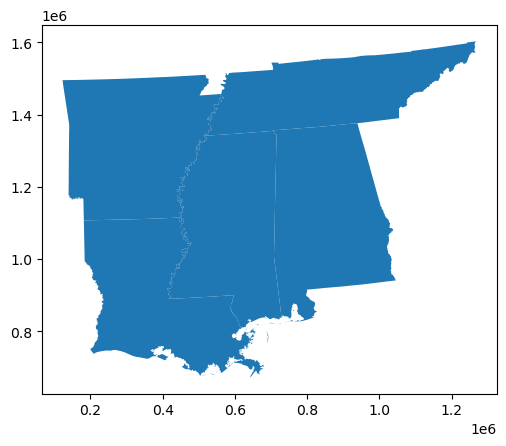

In [5]:
# plot geospatial data from our GeoDataFrame
gdf_states.plot()

Notice the units of the axes. These are the same units as described in the CRS, Cartesian X/Y in meters.

Also notice how we didn't specify which column of the ```gdf_states``` GeoDataFrame to plot. GeoPandas automatically plots the column named 'geometry'. If we had multiple GeoSeries columns (containing geospatial shapes) we would need to specify the column name if we wanted to override the default plotting of the geometery column.

What if we wanted to plot our data such that the axes show latitude and longitude instead of meters? We could "reproject" to the geographic CRS EPSG:4326 for the plot like this: 

<Axes: >

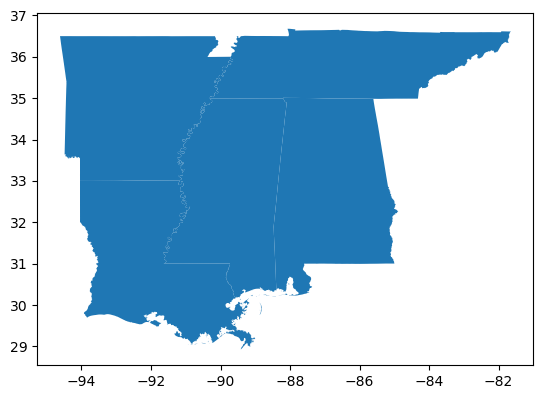

In [6]:
# plot geospatial data from our GeoDataFrame in a new CRS
gdf_states.to_crs('EPSG:4326').plot()

Note that we didn't overwrite our GeoDataFrame with a new CRS here, we are simply reprojecting for the plot and not saving the result. You can double check this if you want by looking at the output of ```gdf_states.crs``` again, as we did earlier. We'll see how to reproject a GeoDataFrame "in place" (overwriting the data) a little later.

# VI. General Methods and Attributes of GeoSeries

There is a lot of information you can pull out of the shape objects in a GeoSeries. Let's look at a few of the available options that may be useful. These methods work on the entire GeoSeries (all the shapes at once) and some of them also work on individual shapes from the GeoSeries. We'll only cover a few here.

First, let's look at a single shape object in the GeoSeries. We'll grab the Mississippi multipolygon and show that it is a Shapely geometry object.

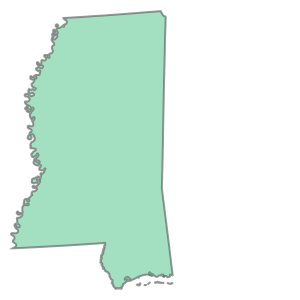

In [7]:
# visual of a single shape in the GeoSeries
MS = gdf_states.geometry.loc[3]
MS

It should make sense now why this shape is a group of polygons called a multipolygon- all the little barrier islands!

In [8]:
# showing this is a shapely geometry object
type(MS)

shapely.geometry.multipolygon.MultiPolygon

## GeoSeries.boundary

Gives you just the shape outline

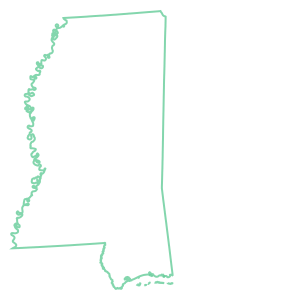

In [9]:
MS.boundary

## GeoSeries.area

In [10]:
MS.area

123472067435.08586

What units is this? It is based on the CRS units of meters, so the area is in square meters.

In [11]:
# areas for all the states is square km
gdf_states.area /1E6

0    133892.928596
1    137782.045408
2    109112.376774
3    123472.067435
4    122007.370915
dtype: float64

In [12]:
# save the result to a new column in the GeoDataFrame
gdf_states['area_km2'] = gdf_states.area /1E6
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,area_km2
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524....",133892.928596
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1...",137782.045408
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1...",109112.376774
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0...",123472.067435
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125....",122007.370915


## GeoSeries.bounds

Gives you the minx, miny, maxx, maxy bounds of the object in CRS units (here, meters)

In [13]:
MS.bounds

(412278.6868907034, 810297.8049194204, 729144.9127503433, 1355271.6370484084)

Let's see how ```.bounds``` works on the entire GeoSeries.

In [14]:
gdf_states.bounds

,minx,miny,maxx,maxy
0,704900.924303,8.244956e+05,1.044933e+06,1.376504e+06
1,122656.347245,1.107309e+06,5.683809e+05,1.510471e+06
2,514676.038729,1.341743e+06,1.267114e+06,1.603146e+06
3,412278.686891,8.102978e+05,7.291449e+05,1.355272e+06
4,181691.061148,6.728742e+05,6.924772e+05,1.115187e+06


Let's look at some more methods that work on the full GeoSeries of shape objects

## GeoSeries.total_bounds

Gives you a single minx, miny, maxx, maxy bound of all the shapes combined 

In [15]:
gdf_states.total_bounds

array([ 122656.3472447 ,  672874.19952676, 1267114.18116978,
       1603146.05504077])

## GeoSeries.count_geometries()

For multi-geometries, this counts how many shapes are with the shape (e.g. polygons in a multipolygon). This will return a value of 1 for non multi-geometries.

In [16]:
gdf_states.count_geometries()

0     5
1     1
2     1
3     8
4    42
dtype: int32

## GeoSeries.count_coordinates()

Gives you the number of nodes (points) that make up each shape

In [17]:
gdf_states.count_coordinates()

0    1842
1    2387
2    2258
3    2769
4    5474
dtype: int32

## GeoSeries.get_coordinates()

Pulls the x and y value of each point in each shape and puts them into separate x/y columns

In [18]:
gdf_states.get_coordinates()

,x,y
0,760323.730743,8.574747e+05
0,760524.681315,8.577000e+05
0,761002.719789,8.582361e+05
0,761316.242610,8.587162e+05
0,761602.662957,8.590779e+05
...,...,...
4,182574.663133,1.065043e+06
4,182571.506252,1.065395e+06
4,182532.317766,1.066695e+06
4,182423.445339,1.070922e+06


You can find the full list of [GeoSeries general methods and attributes in the GeoPandas Documentation](https://geopandas.org/en/stable/docs/reference/geoseries.html#general-methods-and-attributes).

# VII. Showing Multiple GeoSeries on a Single Figure

Let's read another shapefile containing the centerlines of some large rivers and plot them along with the state boundaries in a single figure.

In [161]:
# get river data from shapefile into a GeoDataFrame
gdf_rivers = gpd.read_file("data/natural_earth_rivers/ms_clipped_major_rivers/ms_clipped_major_rivers.shp")
gdf_rivers

,scalerank,featurecla,name,rivernum,ne_id,wikidataid,geometry
0,8,River,Bayou Lafourche,916.0,1159128577,Q2892300,"LINESTRING (568357.042 689163.124, 565180.878 ..."
1,7,River,Pearl,528.0,1159122089,Q1739672,"MULTILINESTRING ((635175.29 1145225.449, 63724..."
2,6,River,Alabama,251.0,1159114979,Q558643,"MULTILINESTRING ((799076.718 1018795.098, 7983..."
3,8,River,Tombigbee,710.0,1159126229,Q2297877,"LINESTRING (700410.717 1322268.779, 702668.212..."
4,7,River,Red,414.0,1159119701,Q156032,"LINESTRING (331751.24 925190.299, 332215.567 9..."
...,...,...,...,...,...,...,...
70,10,River,St. Francis,23283.0,1159108133,Q1108022,"LINESTRING (499575.978 1397371.49, 499957.074 ..."
71,11,River,Hatchie,22539.0,1159139009,Q5681137,"LINESTRING (613963.025 1404839.47, 614746.904 ..."
72,12,River,Little Red,NaN,1746333499,Q6651505,"LINESTRING (364723.209 1390543.547, 363354.685..."
73,11,River,Cache,22542.0,1159139021,Q5015966,"LINESTRING (438432.924 1394010.936, 438485.073..."


Unlike in GIS, there is no "on the fly" reprojection with GeoPandas or any other Python package. You need to be aware of the CRS's that your different datasets are using and make sure they match in order for the data to overlay correctly in a figure.

Let's check the CRS of ```gdf_rivers```

In [20]:
# check the crs
gdf_rivers.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Excellent, this data is also in EPSG:5070, meaning ```gdf_states``` and ```gdf_rivers``` should overlay correctly if we plot them together.

To plot more than one GeoSeries you must first create an 'Axes' object which is like a base figure, then plot you can plot more GeoSeries on top of it like this:

<Axes: >

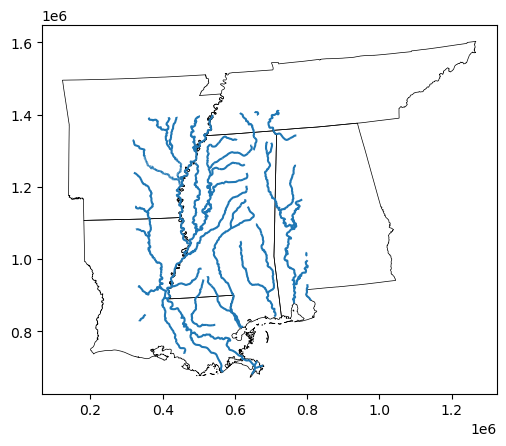

In [21]:
# create the base figure called ax and plot the states on it
base = gdf_states.plot(facecolor='none',edgecolor='black',lw=0.5)

# add the rivers on top of the base figure
gdf_rivers.plot(ax=base)

# VIII. Loading Data from a Geodatabase into a GeoDataFrame

The geodatabase (.gdb) format is proprietary to ESRI, the developer of ArcGIS, however, GeoPandas ```.read_file()```is able to load data from a geodatabase. 

Let's load superfund site data from a geodatabase. Superfund sites are locations in the US where hazardous substances, pollutants, or contaminants are known or suspected to be released. The US Environmental Protection Agency (EPA) maintains the National Priorities List (NPL) of superfund sites. The NPL contains data that documents these sites and their clean up. 

The data file we will work with has been subset from a much larger publicly available data file by filtering for selected data columns for sites in Mississippi that include geospatial location. [The larger data file can be obtained from data.gov](https://catalog.data.gov/dataset/npl-superfund-site-boundaries-epa9), if you are interested.   

In [22]:
gdf_sites=gpd.read_file('data/EPA_superfund_boundaries/MS_EPA_NPL_Site_Boundaries.gdb')
gdf_sites

,EPA_PROGRAM,EPA_ID,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,URL_ALIAS_TXT,NPL_STATUS_CODE,CITY_NAME,COUNTY,STATE_CODE,ZIP_CODE,geometry
0,Superfund Remedial,MSD056029648,POTTER CO.,0.012505,Square Miles,https://www.epa.gov/superfund/Potter,R,WESSON,COPIAH,MS,39191,"MULTIPOLYGON (((-90.39347 31.71068, -90.39161 ..."
1,Superfund Remedial,MSD980601736,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,https://www.epa.gov/superfund/walcotte-chemica...,D,GREENVILLE,WASHINGTON,MS,38701,"MULTIPOLYGON (((-91.05367 33.41172, -91.05336 ..."
2,Superfund Remedial,MSD980840045,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,https://www.epa.gov/superfund/newsom-brothers,D,COLUMBIA,MARION,MS,39429,"MULTIPOLYGON (((-89.83172 31.24718, -89.82803 ..."
3,Superfund Remedial,MSD008154486,"CHEMFAX, INC.",0.030808,Square Miles,https://www.epa.gov/superfund/chemfax,F,GULFPORT,HARRISON,MS,39505,"MULTIPOLYGON (((-89.09194 30.4285, -89.08924 3..."
4,Superfund Remedial,MSD000828558,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,https://www.epa.gov/superfund/southeastern-woo...,F,CANTON,MADISON,MS,39046,"MULTIPOLYGON (((-90.01943 32.61852, -90.01559 ..."
5,Superfund Remedial,MSD000272385,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,https://www.epa.gov/superfund/red-panther-chem...,D,CLARKSDALE,COAHOMA,MS,38614,"MULTIPOLYGON (((-90.56292 34.18858, -90.56229 ..."
6,Superfund Remedial,MSD990866329,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,https://www.epa.gov/superfund/kerr-mcgee-chemi...,F,COLUMBUS,LOWNDES,MS,39701,"MULTIPOLYGON (((-88.41026 33.51039, -88.40898 ..."
7,Superfund Remedial,MSD004006995,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,https://www.epa.gov/superfund/american-creosot...,F,LOUISVILLE,WINSTON,MS,39339,"MULTIPOLYGON (((-89.06084 33.11378, -89.06047 ..."
8,Superfund Remedial,MSD046497012,DAVIS TIMBER COMPANY,0.040010,Square Miles,https://www.epa.gov/superfund/davis-timber,D,HATTIESBURG,LAMAR,MS,39401,"MULTIPOLYGON (((-89.40309 31.34649, -89.39912 ..."
9,Superfund Remedial,MSD980710941,FLOWOOD SITE,0.076644,Square Miles,https://www.epa.gov/superfund/flowood,D,FLOWOOD,RANKIN,MS,39208,"MULTIPOLYGON (((-90.1449 32.30375, -90.14488 3..."


This geodatabase is very simple, as it only contains one GIS data layer of multipolygon objects. This will rarely be the case when you are working with geodatabases. Before we move on, let's look at the tools you can use to see the names of the layers in a geodatabase and how you would read in a particular data layer if you had more than one. We need to import an additional package for this called pyogrio (we've already imported it in the beginning of our notebook).

In [23]:
# use the pyogrio package to list all the layer names in a geodatabase
pyogrio.list_layers('data/EPA_superfund_boundaries/MS_EPA_NPL_Site_Boundaries.gdb')

array([['MS_EPA_NPL_Site_Boundaries', 'MultiPolygon']], dtype=object)

This output is indicating that all the data in our geodatabase is stored on a single GIS data layer called 'MS_EPA_NPL_Site_Boundaries' and the layer's contents are multipolygons. If you are familiar with GIS, you know that there could be many more layer names in this list. If we had more layers the ```pyogrio.list_layers()``` output might look like this:

```array([['MS_EPA_NPL_Site_Boundaries', 'MultiPolygon'],['some_other_layer_name', 'layer_geometry_type'],['some_other_layer_name', 'layer_geometry_type']], dtype=object)```



To load data from a specific layer into a GeoDataFrame we simply need to add the layer parameter when we read the geodatabase, like this:

In [24]:
gdf_sites=gpd.read_file('data/EPA_superfund_boundaries/MS_EPA_NPL_Site_Boundaries.gdb', layer='MS_EPA_NPL_Site_Boundaries')
gdf_sites

,EPA_PROGRAM,EPA_ID,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,URL_ALIAS_TXT,NPL_STATUS_CODE,CITY_NAME,COUNTY,STATE_CODE,ZIP_CODE,geometry
0,Superfund Remedial,MSD056029648,POTTER CO.,0.012505,Square Miles,https://www.epa.gov/superfund/Potter,R,WESSON,COPIAH,MS,39191,"MULTIPOLYGON (((-90.39347 31.71068, -90.39161 ..."
1,Superfund Remedial,MSD980601736,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,https://www.epa.gov/superfund/walcotte-chemica...,D,GREENVILLE,WASHINGTON,MS,38701,"MULTIPOLYGON (((-91.05367 33.41172, -91.05336 ..."
2,Superfund Remedial,MSD980840045,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,https://www.epa.gov/superfund/newsom-brothers,D,COLUMBIA,MARION,MS,39429,"MULTIPOLYGON (((-89.83172 31.24718, -89.82803 ..."
3,Superfund Remedial,MSD008154486,"CHEMFAX, INC.",0.030808,Square Miles,https://www.epa.gov/superfund/chemfax,F,GULFPORT,HARRISON,MS,39505,"MULTIPOLYGON (((-89.09194 30.4285, -89.08924 3..."
4,Superfund Remedial,MSD000828558,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,https://www.epa.gov/superfund/southeastern-woo...,F,CANTON,MADISON,MS,39046,"MULTIPOLYGON (((-90.01943 32.61852, -90.01559 ..."
5,Superfund Remedial,MSD000272385,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,https://www.epa.gov/superfund/red-panther-chem...,D,CLARKSDALE,COAHOMA,MS,38614,"MULTIPOLYGON (((-90.56292 34.18858, -90.56229 ..."
6,Superfund Remedial,MSD990866329,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,https://www.epa.gov/superfund/kerr-mcgee-chemi...,F,COLUMBUS,LOWNDES,MS,39701,"MULTIPOLYGON (((-88.41026 33.51039, -88.40898 ..."
7,Superfund Remedial,MSD004006995,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,https://www.epa.gov/superfund/american-creosot...,F,LOUISVILLE,WINSTON,MS,39339,"MULTIPOLYGON (((-89.06084 33.11378, -89.06047 ..."
8,Superfund Remedial,MSD046497012,DAVIS TIMBER COMPANY,0.040010,Square Miles,https://www.epa.gov/superfund/davis-timber,D,HATTIESBURG,LAMAR,MS,39401,"MULTIPOLYGON (((-89.40309 31.34649, -89.39912 ..."
9,Superfund Remedial,MSD980710941,FLOWOOD SITE,0.076644,Square Miles,https://www.epa.gov/superfund/flowood,D,FLOWOOD,RANKIN,MS,39208,"MULTIPOLYGON (((-90.1449 32.30375, -90.14488 3..."


Moving on, let's check what CRS this data uses.

In [25]:
gdf_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

It's in a different CRS! If we want to look at the locations of the superfund sites in relation to major rivers, we'll have to reproject this data to the CRS of our other GeoSeries, which is EPSG:5070.

Let's reproject this data to EPSG:5070, overwriting the current CRS and geometry column of ```gdf_sites```. To do this we use ```.to_crs()``` with the parameter ```inplace``` set to True. 

In [26]:
gdf_sites.to_crs('epsg:5070',inplace=True)
gdf_sites

,EPA_PROGRAM,EPA_ID,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,URL_ALIAS_TXT,NPL_STATUS_CODE,CITY_NAME,COUNTY,STATE_CODE,ZIP_CODE,geometry
0,Superfund Remedial,MSD056029648,POTTER CO.,0.012505,Square Miles,https://www.epa.gov/superfund/Potter,R,WESSON,COPIAH,MS,39191,"MULTIPOLYGON (((528846.456 975159.623, 529024...."
1,Superfund Remedial,MSD980601736,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,https://www.epa.gov/superfund/walcotte-chemica...,D,GREENVILLE,WASHINGTON,MS,38701,"MULTIPOLYGON (((456762.356 1161146.457, 456792..."
2,Superfund Remedial,MSD980840045,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,https://www.epa.gov/superfund/newsom-brothers,D,COLUMBIA,MARION,MS,39429,"MULTIPOLYGON (((585109.787 926957.316, 585458...."
3,Superfund Remedial,MSD008154486,"CHEMFAX, INC.",0.030808,Square Miles,https://www.epa.gov/superfund/chemfax,F,GULFPORT,HARRISON,MS,39505,"MULTIPOLYGON (((661776.408 841012.053, 662011...."
4,Superfund Remedial,MSD000828558,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,https://www.epa.gov/superfund/southeastern-woo...,F,CANTON,MADISON,MS,39046,"MULTIPOLYGON (((557719.87 1078287.363, 558078...."
5,Superfund Remedial,MSD000272385,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,https://www.epa.gov/superfund/red-panther-chem...,D,CLARKSDALE,COAHOMA,MS,38614,"MULTIPOLYGON (((497070.009 1250277.929, 497129..."
6,Superfund Remedial,MSD990866329,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,https://www.epa.gov/superfund/kerr-mcgee-chemi...,F,COLUMBUS,LOWNDES,MS,39701,"MULTIPOLYGON (((699556.86 1188225.895, 699674...."
7,Superfund Remedial,MSD004006995,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,https://www.epa.gov/superfund/american-creosot...,F,LOUISVILLE,WINSTON,MS,39339,"MULTIPOLYGON (((642934.455 1139477.198, 642968..."
8,Superfund Remedial,MSD046497012,DAVIS TIMBER COMPANY,0.040010,Square Miles,https://www.epa.gov/superfund/davis-timber,D,HATTIESBURG,LAMAR,MS,39401,"MULTIPOLYGON (((624938.893 940712.324, 625314...."
9,Superfund Remedial,MSD980710941,FLOWOOD SITE,0.076644,Square Miles,https://www.epa.gov/superfund/flowood,D,FLOWOOD,RANKIN,MS,39208,"MULTIPOLYGON (((548194.945 1042527.015, 548203..."


Notice the nodes of each multipolygon have changed from units of decimal degrees to units of meters. Let's double check the new CRS info.

In [27]:
gdf_sites.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Great! All our GeoSeries now have the same EPSG:5070 CRS. Let's plot the state boundaries, rivers, and superfund sites on a single figure.

<Axes: >

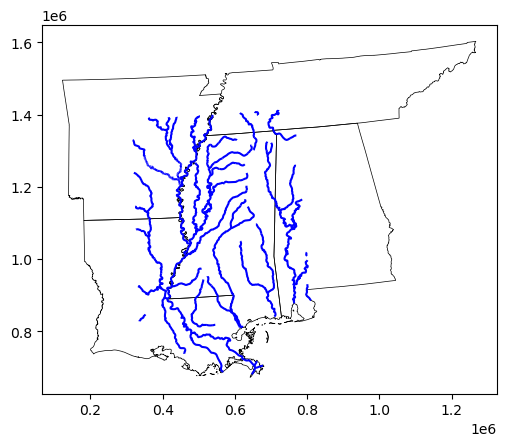

In [28]:
base = gdf_states.plot(facecolor='none',edgecolor='black',lw=0.5)
gdf_rivers.plot(ax=base,color='blue')
gdf_sites.plot(ax=base,color='orange')

What happened, why can't we see the orange sites??

If we were using a fancier package for plotting (like folium) we could zoom in and see them, but with this simple static plotting the problem is that the sites are too small to see at this scale.  We can visualize the sites at this scale by plotting their centroid points, which will automatically scale to be visible.

# IX. Geometric Constructive Functions

https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html

## Centroid 

In [29]:
# create a new GeoSeries in the GeoDataFrame that contains the centroid (point) of each multipolygon
gdf_sites['centroid']=gdf_sites.geometry.centroid
gdf_sites

,EPA_PROGRAM,EPA_ID,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,URL_ALIAS_TXT,NPL_STATUS_CODE,CITY_NAME,COUNTY,STATE_CODE,ZIP_CODE,geometry,centroid
0,Superfund Remedial,MSD056029648,POTTER CO.,0.012505,Square Miles,https://www.epa.gov/superfund/Potter,R,WESSON,COPIAH,MS,39191,"MULTIPOLYGON (((528846.456 975159.623, 529024....",POINT (528900.434 975036.499)
1,Superfund Remedial,MSD980601736,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,https://www.epa.gov/superfund/walcotte-chemica...,D,GREENVILLE,WASHINGTON,MS,38701,"MULTIPOLYGON (((456762.356 1161146.457, 456792...",POINT (456738.236 1161074.926)
2,Superfund Remedial,MSD980840045,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,https://www.epa.gov/superfund/newsom-brothers,D,COLUMBIA,MARION,MS,39429,"MULTIPOLYGON (((585109.787 926957.316, 585458....",POINT (585592.82 926721.66)
3,Superfund Remedial,MSD008154486,"CHEMFAX, INC.",0.030808,Square Miles,https://www.epa.gov/superfund/chemfax,F,GULFPORT,HARRISON,MS,39505,"MULTIPOLYGON (((661776.408 841012.053, 662011....",POINT (662013.455 841156.905)
4,Superfund Remedial,MSD000828558,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,https://www.epa.gov/superfund/southeastern-woo...,F,CANTON,MADISON,MS,39046,"MULTIPOLYGON (((557719.87 1078287.363, 558078....",POINT (557961.9 1078231.921)
5,Superfund Remedial,MSD000272385,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,https://www.epa.gov/superfund/red-panther-chem...,D,CLARKSDALE,COAHOMA,MS,38614,"MULTIPOLYGON (((497070.009 1250277.929, 497129...",POINT (497157.767 1250143.565)
6,Superfund Remedial,MSD990866329,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,https://www.epa.gov/superfund/kerr-mcgee-chemi...,F,COLUMBUS,LOWNDES,MS,39701,"MULTIPOLYGON (((699556.86 1188225.895, 699674....",POINT (700002.706 1188255.288)
7,Superfund Remedial,MSD004006995,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,https://www.epa.gov/superfund/american-creosot...,F,LOUISVILLE,WINSTON,MS,39339,"MULTIPOLYGON (((642934.455 1139477.198, 642968...",POINT (643097.268 1138951.508)
8,Superfund Remedial,MSD046497012,DAVIS TIMBER COMPANY,0.040010,Square Miles,https://www.epa.gov/superfund/davis-timber,D,HATTIESBURG,LAMAR,MS,39401,"MULTIPOLYGON (((624938.893 940712.324, 625314....",POINT (625126.479 940583.052)
9,Superfund Remedial,MSD980710941,FLOWOOD SITE,0.076644,Square Miles,https://www.epa.gov/superfund/flowood,D,FLOWOOD,RANKIN,MS,39208,"MULTIPOLYGON (((548194.945 1042527.015, 548203...",POINT (548240.763 1042210.438)


See how we can have more than one column that is a GeoSeries? The two columns of geospatial shapes are both GeoSeries. If we print the data types of all the columns we should see that we have two GeoSeries now. 

In [30]:
# check out the data types
gdf_sites.dtypes

EPA_PROGRAM          object
EPA_ID               object
SITE_NAME            object
GIS_AREA            float64
GIS_AREA_UNITS       object
URL_ALIAS_TXT        object
NPL_STATUS_CODE      object
CITY_NAME            object
COUNTY               object
STATE_CODE           object
ZIP_CODE             object
geometry           geometry
centroid           geometry
dtype: object

As mentioned earlier, the default behavior when plotting a GeoSeries in a GeoDataFrame is to plot whatever shapes are in the column named geometry. If you want to plot a different GeoSeries, you have to specify the column name like we do below with ```gdf_sites.centroid.plot()```

Trying our plot of states, rivers, and superfund sites again.

<Axes: >

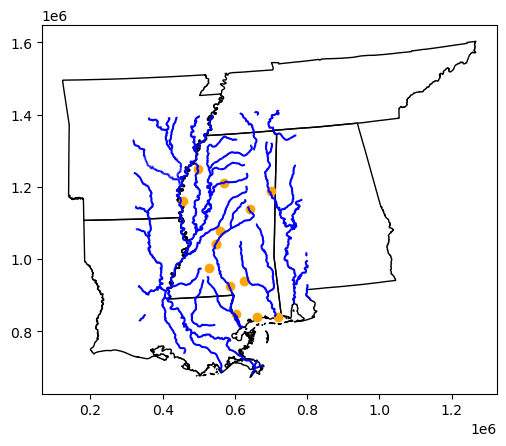

In [31]:
base = gdf_states.plot(facecolor='none',edgecolor='black')
gdf_rivers.plot(ax=base,color='blue')
gdf_sites.centroid.plot(ax=base,color='orange')

Ooof, nearly all the superfund sites are near major rivers or on the coast. That can't be good for water quality! We'll use some additonal functions to see how close these sites are to the major rivers in our data.

## Buffer

First, let's make some simple buffers around our rivers. The [GeoPandas API reference](https://geopandas.org/en/stable/docs/reference.html) is where you should go to find out about all the parameters that you can input to a GeoPandas function. Here's the direct link to the page for [.buffer()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html).

(800000.0, 900000.0)

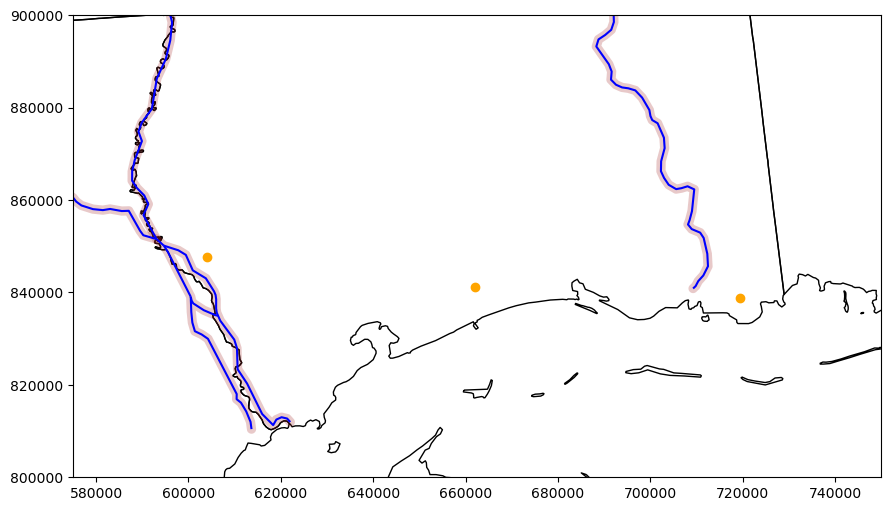

In [162]:
# 100 meter buffer
gdf_rivers["buffer_100m"] = gdf_rivers.buffer(100)

# 1000 meter buffer
gdf_rivers["buffer_1000m"] = gdf_rivers.buffer(1000)

# plot
base = gdf_states.plot(facecolor='none',edgecolor='black',figsize=(12,6)) # larger figure than default
gdf_sites.centroid.plot(ax=base,color='orange')
gdf_rivers.geometry.plot(ax=base,color='blue')
gdf_rivers.buffer_1000m.plot(ax=base,color='brown',alpha=0.25)

# change x and y extents
base.set_xlim(0.575E6,0.75E6)
base.set_ylim(.8E6,.9E6)

Notice the few things we added to our plotting code. We've changed the figure size with the ```figsize``` parameter and we've changed the x and y extents of the plot with the functions ```.set_xlim()```, ```.set_ylim()```. These changes result in a larger figure that is zoomed in on coastal Mississippi.

## Convex Hull
For a geometry with at least 3 points, the convex hull is the smallest convex Polygon containing all the points of the geometry. We'll create a convex hull polygon for each state and then plot the Mississippi state multipolygon and convex hull polygon on the same figure.

In [33]:
gdf_states['convex_hulls']=gdf_states.convex_hull
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,area_km2,convex_hulls
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524....",133892.928596,"POLYGON ((736756.646 824495.603, 736654.747 82..."
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1...",137782.045408,"POLYGON ((181832.229 1107309.209, 181691.061 1..."
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1...",109112.376774,"POLYGON ((514911.947 1341742.94, 514729.675 13..."
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0...",123472.067435,"POLYGON ((617900.651 810297.805, 617477.556 81..."
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125....",122007.370915,"POLYGON ((642111.692 672874.2, 495055.411 6770..."


<Axes: >

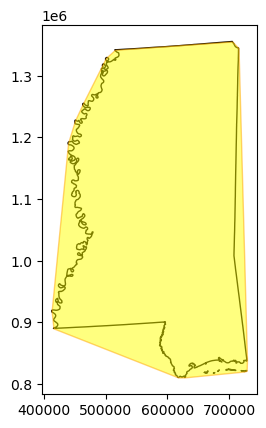

In [34]:
base = gdf_states.loc[gdf_states.STUSPS=='MS'].plot(facecolor='none',edgecolor='black')
gdf_states.loc[gdf_states.STUSPS=='MS'].convex_hulls.plot(ax=base,facecolor='yellow',edgecolor='orange',alpha=0.5)

## Envelope

An envelope is the smallest rectangular polygon (with sides parallel to the coordinate axes) that contains a geometry.

In [35]:
gdf_states['envelopes']=gdf_states.envelope
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,area_km2,convex_hulls,envelopes
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524....",133892.928596,"POLYGON ((736756.646 824495.603, 736654.747 82...","POLYGON ((704900.924 824495.603, 1044933.241 8..."
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1...",137782.045408,"POLYGON ((181832.229 1107309.209, 181691.061 1...","POLYGON ((122656.347 1107309.209, 568380.887 1..."
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1...",109112.376774,"POLYGON ((514911.947 1341742.94, 514729.675 13...","POLYGON ((514676.039 1341742.94, 1267114.181 1..."
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0...",123472.067435,"POLYGON ((617900.651 810297.805, 617477.556 81...","POLYGON ((412278.687 810297.805, 729144.913 81..."
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125....",122007.370915,"POLYGON ((642111.692 672874.2, 495055.411 6770...","POLYGON ((181691.061 672874.2, 692477.198 6728..."


<Axes: >

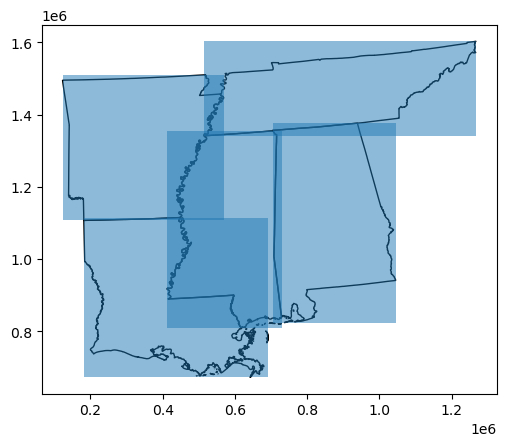

In [36]:
base = gdf_states.plot(facecolor='none',edgecolor='black')
gdf_states.envelopes.plot(ax=base,alpha=0.5)

## Union All

Returns a single shape (not a GeoSeries!) containing the union of all geometries in the GeoSeries.

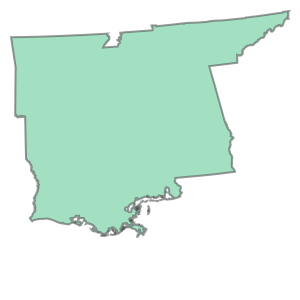

In [37]:
gdf_states.union_all()

In [38]:
type(gdf_states.union_all())

shapely.geometry.multipolygon.MultiPolygon

# Binary (True/False) Functions

These are functions that operate on a GeoSeries and return the result True or False for each shape in the GeoSeries

## Intersects

In [39]:
pearl_river = gdf_rivers.loc[1,"geometry"]

<Axes: >

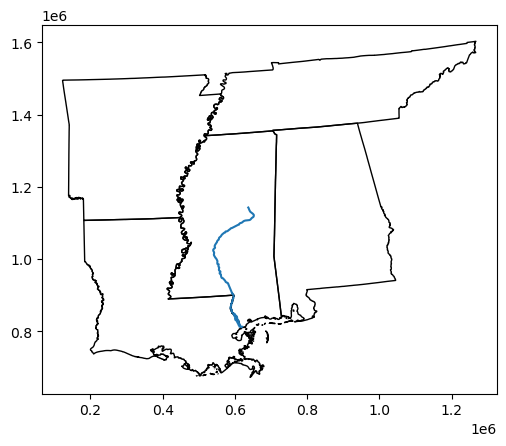

In [40]:
base = gdf_states.plot(facecolor='none',edgecolor='black')
gdf_rivers.loc[gdf_rivers.name=='Pearl'].plot(ax=base)

In [41]:
gdf_states['intersects_pearl']=gdf_states.intersects(pearl_river)
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,area_km2,convex_hulls,envelopes,intersects_pearl
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524....",133892.928596,"POLYGON ((736756.646 824495.603, 736654.747 82...","POLYGON ((704900.924 824495.603, 1044933.241 8...",False
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1...",137782.045408,"POLYGON ((181832.229 1107309.209, 181691.061 1...","POLYGON ((122656.347 1107309.209, 568380.887 1...",False
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1...",109112.376774,"POLYGON ((514911.947 1341742.94, 514729.675 13...","POLYGON ((514676.039 1341742.94, 1267114.181 1...",False
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0...",123472.067435,"POLYGON ((617900.651 810297.805, 617477.556 81...","POLYGON ((412278.687 810297.805, 729144.913 81...",True
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125....",122007.370915,"POLYGON ((642111.692 672874.2, 495055.411 6770...","POLYGON ((181691.061 672874.2, 692477.198 6728...",True


## Contains and Within

Find whether one shape contains another or similarly, whether one shape is within another. E.g., polygon A *contains* point B, point B is *within* polygon A. It's just two ways of finding the same information. 



In [42]:
# check if each state polygon contains a single superfund site
one_site = gdf_sites.loc[0,"geometry"]

gdf_states.contains(one_site)

0    False
1    False
2    False
3     True
4    False
dtype: bool

In [43]:
# check if 1 state contain any of the superfund sites
one_state = gdf_states.geometry.iloc[0]  # this is Alabama

one_state.contains(gdf_sites.geometry).any()

False

In [44]:
# get at the same information using within instead of contains

# check if any of the superfund sites are within Alabama
gdf_sites.geometry.within(one_state).any()

False

Now for a little added complexity! What if we want to check each state in ```gdf_states``` to see whether they contain any of the superfund sites in our dataset?

We will have to write a function for that and then use ```.apply()```, which will apply our function to each row of a GeoDataFrame. In this case, we'll apply our function to the rows of ```gdf_states```, checking whether each state shape contains any of the superfund sites. We already know that our superfund site data has been subset to Mississippi, so we expect a result of True for Mississippi and False for all other states. Here's how we can do it:

In [71]:
# check if any sites are within each state

def shape_contains_shape(row,sites):
    shape_object = row.geometry  # a single shapely object (the geometry column from each row)
    return shape_object.contains(sites.geometry).any() # this part is the same as we saw above

# apply the function to each row of gdf_states
# and save the output to a new column
# axis=1 indicates that we want to apply the function to each row of gdf_states
gdf_states['has_sites'] = gdf_states.apply(shape_contains_shape,axis=1,args=(gdf_sites,))
gdf_states

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,area_km2,convex_hulls,envelopes,intersects_pearl,has_sites
0,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524....",133892.928596,"POLYGON ((736756.646 824495.603, 736654.747 82...","POLYGON ((704900.924 824495.603, 1044933.241 8...",False,False
1,05,00068085,0400000US05,05,AR,Arkansas,00,134660466558,3122251184,"POLYGON ((122656.347 1495564.869, 122680.321 1...",137782.045408,"POLYGON ((181832.229 1107309.209, 181691.061 1...","POLYGON ((122656.347 1107309.209, 568380.887 1...",False,False
2,47,01325873,0400000US47,47,TN,Tennessee,00,106792311478,2322248149,"POLYGON ((514676.039 1342513.625, 514738.015 1...",109112.376774,"POLYGON ((514911.947 1341742.94, 514729.675 13...","POLYGON ((514676.039 1341742.94, 1267114.181 1...",False,False
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533540877,3914738613,"MULTIPOLYGON (((719751.38 821718.593, 721088.0...",123472.067435,"POLYGON ((617900.651 810297.805, 617477.556 81...","POLYGON ((412278.687 810297.805, 729144.913 81...",True,True
4,22,01629543,0400000US22,22,LA,Louisiana,00,111930452904,23721187320,"MULTIPOLYGON (((687937.424 779840.415, 688125....",122007.370915,"POLYGON ((642111.692 672874.2, 495055.411 6770...","POLYGON ((181691.061 672874.2, 692477.198 6728...",True,False


```.apply()``` is like a loop, applying our function to 1 row of ```gdf_states``` at a time, moving row by row until the end of all the rows in the GeoDataFrame, then returning the results.

Let's check if any of the superfund sites are within the 1000 meter river buffers.

In [131]:
# check if any site centroids are within the 1000 meter river buffers

# this time we'll use within
def shape_within_shape(row, col1, gdf, col2):
    shape1 = row[col1]  # a single shapely object (from a particular column of each row)
    return shape1.within(gdf[col2]).any()

# apply the function to each row of gdf_sites and save the output to a new column
gdf_sites['centroid_in_buff1000'] = gdf_sites.apply(shape_within_shape, axis=1, args=('centroid',gdf_rivers,'buffer_1000m'))
gdf_sites

,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,NPL_STATUS_CODE,geometry,centroid,within_buffer_1000m,centroid_in_buff1000
0,POTTER CO.,0.012505,Square Miles,R,"MULTIPOLYGON (((528846.456 975159.623, 529024....",POINT (528900.434 975036.499),False,False
1,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,D,"MULTIPOLYGON (((456762.356 1161146.457, 456792...",POINT (456738.236 1161074.926),False,False
2,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,D,"MULTIPOLYGON (((585109.787 926957.316, 585458....",POINT (585592.82 926721.66),False,False
3,"CHEMFAX, INC.",0.030808,Square Miles,F,"MULTIPOLYGON (((661776.408 841012.053, 662011....",POINT (662013.455 841156.905),False,False
4,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,F,"MULTIPOLYGON (((557719.87 1078287.363, 558078....",POINT (557961.9 1078231.921),False,False
5,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,D,"MULTIPOLYGON (((497070.009 1250277.929, 497129...",POINT (497157.767 1250143.565),False,False
6,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,F,"MULTIPOLYGON (((699556.86 1188225.895, 699674....",POINT (700002.706 1188255.288),False,False
7,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,F,"MULTIPOLYGON (((642934.455 1139477.198, 642968...",POINT (643097.268 1138951.508),False,False
8,DAVIS TIMBER COMPANY,0.040010,Square Miles,D,"MULTIPOLYGON (((624938.893 940712.324, 625314....",POINT (625126.479 940583.052),False,False
9,FLOWOOD SITE,0.076644,Square Miles,D,"MULTIPOLYGON (((548194.945 1042527.015, 548203...",POINT (548240.763 1042210.438),False,False


If we scroll to the right to see the new column ```centroid_in_buff1000```, we can see that even though the superfund centroid points we plotted looked very close to our major rivers, none of the centroids are within the 1000 meter river buffers. Parts of the superfund site polygons could be within the buffers though, we'll check that later. 

There are quite a few more GeoPandas functions like this called "Binary Predicates" and they can be found in the [GeoPandas API reference here](https://geopandas.org/en/stable/docs/reference/geoseries.html#binary-predicates)

# Clipping

# Clip Shapes with Another Shape

Clip the rivers to the rectangular envelope for Mississippi.

First, let's work out the syntax for selecting a single Shapely object from a GeoSeries. This means selecting the polygon shape from the envelopes column of the gdf_states GeoDataFrame. The selection, if done correctly, should result in a single shape rendered to the screen, not a column or row of data:

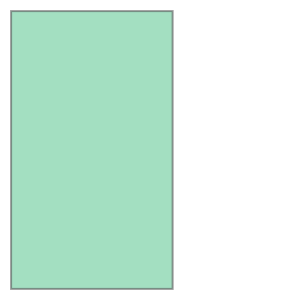

In [66]:
# select a single Shapely polygon (Mississippi envelope)
gdf_states.loc[gdf_states.STUSPS=='MS']['envelopes'].iloc[0]

<Axes: >

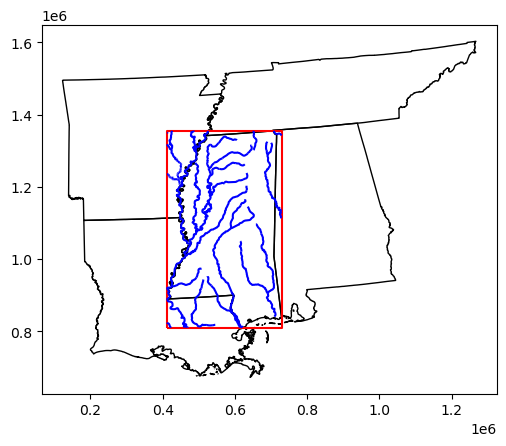

In [65]:
# clip rivers with Mississippi envelope
clipped_rivers = gpd.clip(gdf_rivers, gdf_states.loc[gdf_states.STUSPS=='MS']['envelopes'].iloc[0])

# plot states, Mississippi envelope, and clipped rivers
base = gdf_states.plot(facecolor='none',edgecolor='black')
gdf_states.loc[gdf_states.STUSPS=='MS']['envelopes'].boundary.plot(ax=base,color='red')
clipped_rivers.plot(ax=base,color='blue')

You can also clip raster data (data with pixels or on a grid) with GeoPandas, but for that we will need an additional Python packages. We'll learn how to do that in a subsequent lesson.

# Distance

In [164]:
# dropping more columns that we don't need before we do the calculation
# gdf_sites.drop(columns=['EPA_PROGRAM','EPA_ID','URL_ALIAS_TXT','CITY_NAME','COUNTY','STATE_CODE','ZIP_CODE'],inplace=True)
gdf_rivers.drop(columns=['scalerank','featurecla','rivernum','ne_id','wikidataid'],inplace=True)

In [132]:
sites_with_closest_river_info = gpd.sjoin_nearest(gdf_sites, gdf_rivers, how='left', rsuffix='rivers',distance_col='min_distance', exclusive=True)
sites_with_closest_river_info

,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,NPL_STATUS_CODE,geometry,centroid,within_buffer_1000m,centroid_in_buff1000,index_rivers,name,buffer_100m,buffer_1000m,min_distance
0,POTTER CO.,0.012505,Square Miles,R,"MULTIPOLYGON (((528846.456 975159.623, 529024....",POINT (528900.434 975036.499),False,False,18,Homochitto,"POLYGON ((495895.04 954897.601, 496025.851 956...","POLYGON ((495008.21 955121.929, 495127.922 956...",21246.428527
1,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,D,"MULTIPOLYGON (((456762.356 1161146.457, 456792...",POINT (456738.236 1161074.926),False,False,5,Mississippi,"MULTIPOLYGON (((671688.055 703835.685, 661839....","POLYGON ((457362.132 820758.547, 458939.624 82...",6723.384359
2,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,D,"MULTIPOLYGON (((585109.787 926957.316, 585458....",POINT (585592.82 926721.66),False,False,1,Pearl,"POLYGON ((606347.715 834853.198, 605729.083 83...","POLYGON ((553990.913 985082.112, 551147.955 98...",1669.974406
3,"CHEMFAX, INC.",0.030808,Square Miles,F,"MULTIPOLYGON (((661776.408 841012.053, 662011....",POINT (662013.455 841156.905),False,False,11,Pascagoula,"POLYGON ((691716.803 904701.352, 691720.896 90...","POLYGON ((692515.927 905115.357, 692556.858 90...",47056.660871
4,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,F,"MULTIPOLYGON (((557719.87 1078287.363, 558078....",POINT (557961.9 1078231.921),False,False,1,Pearl,"POLYGON ((606347.715 834853.198, 605729.083 83...","POLYGON ((553990.913 985082.112, 551147.955 98...",11315.505566
5,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,D,"MULTIPOLYGON (((497070.009 1250277.929, 497129...",POINT (497157.767 1250143.565),False,False,50,Big Sunflower,"POLYGON ((490564.425 1267274.235, 490565.43 12...","POLYGON ((490443.013 1230003.456, 490020.785 1...",976.958196
6,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,F,"MULTIPOLYGON (((699556.86 1188225.895, 699674....",POINT (700002.706 1188255.288),False,False,3,Tombigbee,"POLYGON ((702758.914 1317448.28, 702762.325 13...","POLYGON ((684531.804 1241115.152, 684235.026 1...",2554.975681
7,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,F,"MULTIPOLYGON (((642934.455 1139477.198, 642968...",POINT (643097.268 1138951.508),False,False,1,Pearl,"POLYGON ((606347.715 834853.198, 605729.083 83...","POLYGON ((553990.913 985082.112, 551147.955 98...",3571.552016
8,DAVIS TIMBER COMPANY,0.040010,Square Miles,D,"MULTIPOLYGON (((624938.893 940712.324, 625314....",POINT (625126.479 940583.052),False,False,13,Leaf,"POLYGON ((617216.971 1019624.489, 616876.308 1...","POLYGON ((618104.258 1019473.753, 617781.537 1...",11284.436989
9,FLOWOOD SITE,0.076644,Square Miles,D,"MULTIPOLYGON (((548194.945 1042527.015, 548203...",POINT (548240.763 1042210.438),False,False,1,Pearl,"POLYGON ((606347.715 834853.198, 605729.083 83...","POLYGON ((553990.913 985082.112, 551147.955 98...",819.414481


The results in the min_distance column indicate there are 3 sites that are at least partially in a 1000m river buffer.

Look at index 12. The closest part of the Rockwell International Wheel & Trim superfund polygon is only 528 meters from the Yalobusha River centerline. Let's make a zoomed in plot of this site's polygon and centroid, the Yalobusha River, and the 1000 meter buffer. 

(568000.0, 571000.0)

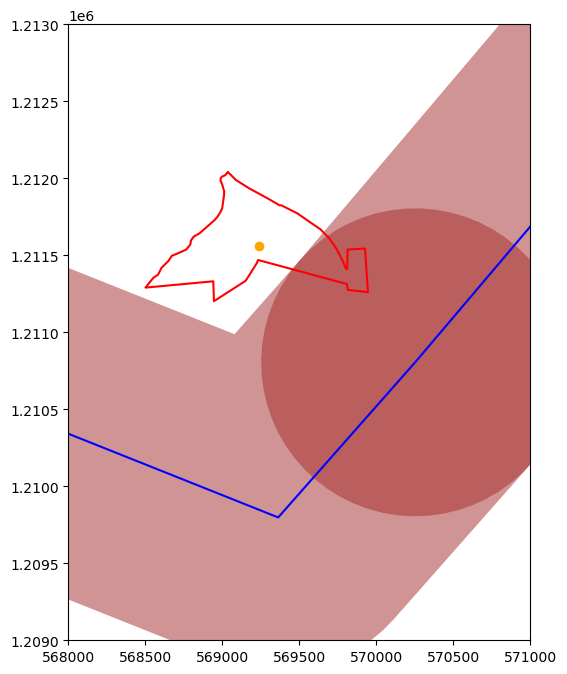

In [165]:
# plot Rockwell International polygon and centroid, Yalobusha River, and 1000 meter buffer

base = gdf_sites.loc[gdf_sites.SITE_NAME.str.contains('ROCKWELL')].boundary.plot(color='red',figsize=(8,8))
gdf_sites.loc[gdf_sites.SITE_NAME.str.contains('ROCKWELL')].centroid.plot(ax=base,color='orange')
gdf_rivers.loc[gdf_rivers.name=='Yalobusha'].plot(ax=base,color='blue')
gdf_rivers.loc[gdf_rivers.name=='Yalobusha']['buffer_1000m'].plot(ax=base,color='brown',alpha=0.5)

# zoom in
base.set_ylim(1.209E6,1.213E6)
base.set_xlim(.568E6,.571E6)

Look at that! The centroid is not in the buffer, but part of the site polygon is. If we wanted to create a column telling us which site polygons lie partially within the river buffers we could use ```.intersects()``` for that.

## Exercise

Create a new column in ```gdf_sites``` called ```intersects_buff1000``` to test whether each site polygon lies at least partially within any of the river buffers (you can use ```.intersects()``` for this). You will need to write a new function called ```shape_intersects_shape``` and apply it to the ```gdf_sites``` GeoDataFrame. Use the ```shape_within_shape``` function that we made earlier as an example.

In [139]:
# add you code here

def shape_intersects_shape(row, col1, gdf, col2):
    shape1 = row[col1]  # a single shapely object (from a particular column of each row)
    return shape1.intersects(gdf[col2]).any()

# apply the function to each row of gdf_sites and save the output to a new column
gdf_sites['intersects_buff1000'] = gdf_sites.apply(shape_intersects_shape, axis=1, args=('geometry',gdf_rivers,'buffer_1000m'))
gdf_sites

,SITE_NAME,GIS_AREA,GIS_AREA_UNITS,NPL_STATUS_CODE,geometry,centroid,within_buffer_1000m,centroid_in_buff1000,intersects_buff1000
0,POTTER CO.,0.012505,Square Miles,R,"MULTIPOLYGON (((528846.456 975159.623, 529024....",POINT (528900.434 975036.499),False,False,False
1,WALCOTTE CHEMICAL CO. WAREHOUSES,0.001875,Square Miles,D,"MULTIPOLYGON (((456762.356 1161146.457, 456792...",POINT (456738.236 1161074.926),False,False,False
2,"NEWSOM BROTHERS/OLD REICHHOLD CHEMICALS, INC.",0.106864,Square Miles,D,"MULTIPOLYGON (((585109.787 926957.316, 585458....",POINT (585592.82 926721.66),False,False,False
3,"CHEMFAX, INC.",0.030808,Square Miles,F,"MULTIPOLYGON (((661776.408 841012.053, 662011....",POINT (662013.455 841156.905),False,False,False
4,SOUTHEASTERN WOOD PRESERVING,0.052808,Square Miles,F,"MULTIPOLYGON (((557719.87 1078287.363, 558078....",POINT (557961.9 1078231.921),False,False,False
5,RED PANTHER CHEMICAL COMPANY,0.013329,Square Miles,D,"MULTIPOLYGON (((497070.009 1250277.929, 497129...",POINT (497157.767 1250143.565),False,False,True
6,KERR-MCGEE CHEMICAL CORP - COLUMBUS,0.101956,Square Miles,F,"MULTIPOLYGON (((699556.86 1188225.895, 699674....",POINT (700002.706 1188255.288),False,False,False
7,AMERICAN CREOSOTE WORKS INC (LOUISVILLE),0.227193,Square Miles,F,"MULTIPOLYGON (((642934.455 1139477.198, 642968...",POINT (643097.268 1138951.508),False,False,False
8,DAVIS TIMBER COMPANY,0.040010,Square Miles,D,"MULTIPOLYGON (((624938.893 940712.324, 625314....",POINT (625126.479 940583.052),False,False,False
9,FLOWOOD SITE,0.076644,Square Miles,D,"MULTIPOLYGON (((548194.945 1042527.015, 548203...",POINT (548240.763 1042210.438),False,False,True


Use ```.sum()``` on the column ```intersects_buff1000``` to show programatically how many sites are at least partially in a 1000 meter river buffer.

In [140]:
# add your code here
gdf_sites.intersects_buff1000.sum()

3

# Aggregation with .dissolve()

## Aggregating Shapes

First lets aggregate rivers with the same name together. We've got repeated river names in ```gdf_rivers```. How do we know this? We can compare the number of rows in ```gdf_rivers``` to the number of unique river names:

In [144]:
print(f'There are {gdf_rivers.shape[0]} rows in gdf_rivers, but only {len(gdf_rivers.name.unique())} unique river names')

There are 75 rows in gdf_rivers, but only 47 unique river names


In [170]:
# test = gdf_rivers[['name','geometry']].dissolve(by='name')
# test
gdf_rivers = gdf_rivers[['name','geometry']].dissolve(by='name',as_index=False,sort=False)

In [172]:
gdf_rivers["buffer_1000m"] = gdf_rivers.buffer(1000)
gdf_rivers

,name,geometry,buffer_1000m
0,Bayou Lafourche,"LINESTRING (568357.042 689163.124, 565180.878 ...","POLYGON ((565168.019 688204.052, 565076.113 68..."
1,Pearl,"MULTILINESTRING ((635175.29 1145225.449, 63724...","POLYGON ((553990.913 985082.112, 551147.955 98..."
2,Alabama,"MULTILINESTRING ((799076.718 1018795.098, 7983...","MULTIPOLYGON (((761973.191 888899.425, 763546...."
3,Tombigbee,"LINESTRING (700410.717 1322268.779, 702668.212...","POLYGON ((684531.804 1241115.152, 684235.026 1..."
4,Red,"LINESTRING (331751.24 925190.299, 332215.567 9...","POLYGON ((332682.261 925796.188, 333174.184 92..."
5,Mississippi,"MULTILINESTRING ((661384.266 717552.704, 65536...","POLYGON ((457362.132 820758.547, 458939.624 82..."
6,White,"MULTILINESTRING ((416109.469 1392893.462, 4164...","POLYGON ((414179.263 1360809.342, 414480.912 1..."
7,Arkansas,"MULTILINESTRING ((316844.853 1329753.717, 3169...","POLYGON ((317361.19 1330625.635, 317444.145 13..."
8,Tennessee,"MULTILINESTRING ((720391.934 1413173.635, 7202...","POLYGON ((697038.903 1386036.161, 697603.927 1..."
9,Perdido,"MULTILINESTRING ((797673.143 900649.647, 79815...","POLYGON ((796712.805 900373.35, 796707.443 900..."


In [ ]:
# plot, rebuffer?

## aggregate data by shape
I may need different data for this






## intersection
## union


# Binary (True/False) Functions
## intersects
## overlaps
## contains

# Geometric Overlay Operations 
## .clip()
## .overlay()

# Other Useful Things 
## distance


# Aggregation
## dissolve

# .explore()


In [ ]:
ax = gdf_states.geometry.boundary.plot(color='black',lw=0.5)#facecolor='none',edgecolor='black')


In [ ]:
import openpyxl
import pandas as pd

In [ ]:
df_toxic = pd.read_csv('data/epa_brownfields_ms/STATE_SINGLE_MS.csv')
df_toxic

In [ ]:
df_toxic.dropna(subset=['LATITUDE83','LONGITUDE83'],inplace=True)
df_toxic

In [ ]:
df_toxic.columns

In [ ]:
df_toxic.dropna(subset=['HDATUM_DESC'],inplace=True)
df_toxic

In [ ]:
df_toxic.HDATUM_DESC.unique()

In [ ]:
df_toxic.SITE_TYPE_NAME.unique()

In [ ]:
df_toxic.INTEREST_TYPES.unique()

In [ ]:
df_toxic.INTEREST_TYPES.dtype

In [ ]:
df_toxic.INTEREST_TYPES.fillna('',inplace=True)

In [ ]:
df_toxic[df_toxic.INTEREST_TYPES.isin(['TRI REPORTER','TSCA SUBMITTER'])]
# df_toxic.query("INTEREST_TYPES.str.contains('TRI')")

In [ ]:
df_toxic.drop(columns=['LOCATION_ADDRESS', 'SUPPLEMENTAL_LOCATION', 'CITY_NAME','FIPS_CODE', 'STATE_CODE',
                       'COUNTRY_NAME','EPA_REGION_CODE','CREATE_DATE', 'UPDATE_DATE', 'US_MEXICO_BORDER_IND',
                       'CONVEYOR','COLLECT_DESC', 'ACCURACY_VALUE','SOURCE_DESC','PGM_SYS_ACRNMS',
                       'NAICS_CODES', 'NAICS_CODE_DESCRIPTIONS','SIC_CODES','SIC_CODE_DESCRIPTIONS',
                       'FEDERAL_FACILITY_CODE', 'FEDERAL_AGENCY_NAME', 'TRIBAL_LAND_CODE','TRIBAL_LAND_NAME',
                       'LOCATION_DESCRIPTION'],inplace=True)
df_toxic

In [ ]:
df_toxic = df_toxic[df_toxic.INTEREST_TYPES.isin(['TRI REPORTER','TSCA SUBMITTER'])]
df_toxic

In [ ]:
# import fiona
# layers=fiona.listlayers("data/acres_frs/ACRES_FRS.kml")
# layers

In [ ]:
# gdf_toxic = gpd.read_file("data/acres_frs/ACRES_FRS.kml", driver="KML")
# gdf_toxic

In [ ]:
study_area = gdf_states.geometry.union_all()
study_area

In [ ]:
gdf_rivers_ms = gpd.clip(gdf_rivers,ms)
gdf_rivers_ms

In [ ]:
# gdf_ms = gpd.read_file("data/tl_2016_28_cousub/tl_2016_28_cousub.shp")
# gdf_ms.head()

In [ ]:
gdf_ms.plot()

In [ ]:
gdf_ms.crs

In [ ]:
gdf_ms = gdf_ms.to_crs('epsg:5070')
gdf_ms.crs

In [ ]:
ms = gdf_ms.geometry.union_all()
ms

In [ ]:
gdf_rivers = gdf_rivers.to_crs('epsg:5070')
gdf_rivers.crs

In [ ]:
gdf_rivers_ms = gpd.clip(gdf_rivers,ms)
gdf_rivers_ms

In [ ]:
gdf_rivers_ms.plot()